In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import networkx as nx
import pandas as pd
import functools

from IPython.display import display, Markdown
from ford_fulkerson_algorithm import ford_fulkerson_algorithm

In [2]:
#config

#colors for iteration Graphs
start_node_color = 'green'
end_node_color = 'red' 
standard_node_color = 'white'

options_residual = {
    'font_size': 30,
    'node_size': 3000,
    'with_labels': True,
    'edgecolors': 'black',
    'linewidths': 5,
    'width': 5,
    'arrowstyle': ']-[',
    'arrowsize': 3,
    }

#Output Definitions
options_final = {
    'font_size': 30,
    'node_size': 3000,
    'with_labels': True,
    'edgecolors': 'black',
    'linewidths': 5,
    'width': 5,
    'arrowstyle': '-|>',
    'arrowsize': 40,
    } 

#Output Definitions
options_original = {
    'font_size': 30,
    'node_size': 3000,
    'with_labels': True,
    'node_color': 'white',
    'edgecolors': 'black',
    'linewidths': 5,
    'width': 5,
    'arrowstyle': '-|>',
    'arrowsize': 40,
    }

edge_label_options_original = {
    'font_size': 25,
    'font_color': 'black',
    'label_pos': 0.5,
    'rotate': False,
    }

edge_label_options_residual = {
    'font_size': 25,
    'font_color': 'black',
    'label_pos': 0.7,
    'rotate': False,
    }


#adjust Setting for Plot
plt.rcParams['figure.figsize']=12,8
plt.rcParams['figure.dpi'] = 60

In [3]:
#observe/on_click functions
def display_uploaded_graph(change, Graph, display_input, display_ford_fulkerson):
    #clear old inputs
    display_input.clear_output()
    display_ford_fulkerson.clear_output()
    Graph.clear()
    
    #read txt-Data and execute as code, get the variables
    start_node, end_node, uploaded_edges, pos = read_uploaded_variables(change)
    
    #add Edges to Graph
    Graph.add_weighted_edges_from(uploaded_edges)
    #get edge Labels to draw them on plot
    edge_labels = nx.get_edge_attributes(Graph,'weight') 
    #draw Graph on plot
    nx.draw(Graph, pos, ** options_original)
    nx.draw_networkx_edge_labels(Graph, pos, edge_labels=edge_labels, **edge_label_options_original)
    
    end_node_slider, start_node_slider = create_start_end_node_sliders(Graph, start_node)
    
    with display_input:
        display(Markdown('## Original Network'))
        plt.show()
        display(start_node_slider)
        display(end_node_slider)

    start_node_slider.observe(functools.partial(output_ford_fulkerson, Graph = Graph, start_node_slider = start_node_slider,  end_node_slider = end_node_slider, display_ford_fulkerson = display_ford_fulkerson, pos = pos, uploaded_edges = uploaded_edges), names = 'value')
    end_node_slider.observe(functools.partial(output_ford_fulkerson, Graph = Graph, start_node_slider = start_node_slider,  end_node_slider = end_node_slider, display_ford_fulkerson = display_ford_fulkerson, pos = pos, uploaded_edges = uploaded_edges), names = 'value')
    #change value to activate observe
    end_node_slider.value = end_node
    

def output_ford_fulkerson(change, Graph, start_node_slider, end_node_slider, display_ford_fulkerson, pos, uploaded_edges):
    display_ford_fulkerson.clear_output()
    
    # convert Graph to residual Graph 
    converted_Graph = convert_graph(Graph, uploaded_edges)
                                    
    # execute Ford-Fulkerson Algorithm
    graphs, df_ford_fulkerson = ford_fulkerson_algorithm(converted_Graph, start_node_slider.value, end_node_slider.value)
    #create final flow graph
    graphs.append(adjust_weight_final_flow_graph(Graph, graphs[-1]))
    
    # display start and end node in different color
    color_nodes = define_node_colors(Graph, end_node_slider, start_node_slider)

    #Display result from Ford Fulkerson
    for i in range(0, len(graphs)):
        #decide on visual parameters to draw network (final Graph different)
        if i != len(graphs)-1:
            options = options_residual 
            edge_label_options = edge_label_options_residual
        elif i == len(graphs)-1:
            options = options_final
            edge_label_options = edge_label_options_original
            
        #get variable plot variables
        colors_edges = nx.get_edge_attributes(graphs[i], 'color').values()
        colors_edges = 'black' if len(colors_edges) == 0 else colors_edges
        labels = nx.get_edge_attributes(graphs[i], 'weight')

        #draw graph on plot
        nx.draw(graphs[i], pos, **options, edge_color=colors_edges, node_color=color_nodes)
        nx.draw_networkx_edge_labels(graphs[i], pos, edge_labels=labels, **edge_label_options)

        with display_ford_fulkerson:
            if i == 0:
                display(Markdown('## Adjusted Residual Network'))
            elif i == len(graphs)-1:
                display(Markdown('## Final Flow Network'))
            else:
                display(Markdown('## ' + str(i) + '. Iteration'))
                print(df_ford_fulkerson.iloc[i - 1, 1:].to_string())
            plt.show()
            
    with display_ford_fulkerson:
        if len(df_ford_fulkerson)== 0:
            display(Markdown('No augmenting Path found.'))
        else:
            display(df_ford_fulkerson.style.hide_index())
            display(Markdown('#### The accumulated maximal Flow is ' + str(df_ford_fulkerson.iloc[:,-1].sum()) +' Units.'))

In [4]:
# functions to shorten code
def read_uploaded_variables(change):
    # read txt-Data and execute as code, get the some values
    for key in change['new']:
        string = change['new'][key]['content'].decode('utf-8')
        var_to_value = {}
        exec(string, var_to_value)
        
        #get variables
        pos = var_to_value['pos']
        uploaded_edges = var_to_value['edges']
        start_node = var_to_value['start_node']
        end_node = var_to_value['end_node']
    return start_node, end_node, uploaded_edges, pos


def create_start_end_node_sliders(Graph, start_node):
    # if start/end node is given take these, else take the first and the last node
    first_node = min(Graph.nodes)
    # definiton slider
    start_node_slider = widgets.IntSlider(value=start_node, min=first_node, max=Graph.number_of_nodes(),
                                          description='Startnode:', continuous_update=False)
    #gets changed to end node to activate oberserve function
    end_node_slider = widgets.IntSlider(value=start_node, min=first_node, max=Graph.number_of_nodes(),
                                        description='Endnode:', continuous_update=False)
    return end_node_slider, start_node_slider

def define_node_colors(Graph, end_node_slider, start_node_slider):
    color_nodes = []
    #define color start and end_node
    for i in Graph.nodes:
        if start_node_slider.value == i:
            color_nodes.append(start_node_color)
        elif end_node_slider.value == i:
            color_nodes.append(end_node_color)
        else:
            color_nodes.append(standard_node_color)
    return color_nodes

def convert_graph(Graph, uploaded_edges):
    converted_Graph = Graph.copy()
    copy_uploaded_edges = uploaded_edges.copy()
    weight = 0
    end_node_id = 1
    start_node_id = 0
    
    #creade inverse edges
    for i in range(0, len(uploaded_edges)):
        copy_uploaded_edges.append((uploaded_edges[i][end_node_id], uploaded_edges[i][start_node_id], weight))

    converted_Graph.add_weighted_edges_from(copy_uploaded_edges)
    return converted_Graph


def adjust_weight_final_flow_graph(original_Graph, Graph_last_iteration):
    final_Graph = original_Graph.copy()
    
    # create graph without inverse edges (only edges in uploaded graph)
    # display used capacity in edge-weight-label as used _apacity/ max_capacity
    for start_edge, end_edge in final_Graph.edges():
        if (start_edge, end_edge) in Graph_last_iteration.edges():
            final_Graph[start_edge][end_edge]['weight'] = str(
                Graph_last_iteration[end_edge][start_edge]['weight']) + '/' + str(
                final_Graph[start_edge][end_edge]['weight'])
    return final_Graph




In [5]:
#Create Widgets on start
display_input = widgets.Output()
display_ford_fulkerson = widgets.Output()
uploader = widgets.FileUpload(accept='.txt', multiple=False )

#create empty Graph
G = nx.DiGraph()

#Displayed Widgets
display(Markdown('# Ford-Fulkerson Algorithm')) 
display(Markdown('Upload your Graph:')) 
display(uploader)
display(display_input)
display(display_ford_fulkerson)

#when Graph uploaded, use Prim Algorithm and Display result
uploader.observe(functools.partial(display_uploaded_graph, Graph = G, 
                                   display_input =display_input, 
                                   display_ford_fulkerson= display_ford_fulkerson), 
                 names = 'value')

# Ford-Fulkerson Algorithm

Upload your Graph:

FileUpload(value={}, accept='.txt', description='Upload')

Output()

Output()

### Legend

#### Original Network

u(i,j) = Capacity


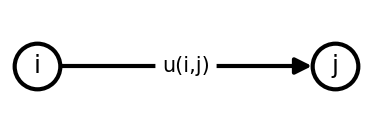

#### Residual Network

uf(i,j) = Residual Capacity


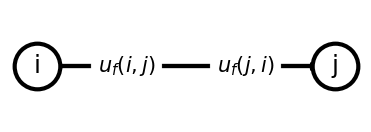

#### Maximal Flow Network

f(i,j) = Flow
u(i,j) = Capacity


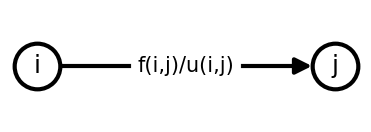

In [7]:
#Legend

# explicitly set positions
pos = {"i": (0, 0), "j": (1, 0)}


#Original Network
G = nx.DiGraph()
fig = plt.gcf()
fig.set_size_inches(6, 2)

G.add_edge("i", "j", weight = "u(i,j)")
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, pos, **options_original) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, **edge_label_options_original)
           

display(Markdown('### Legend')) 
display(Markdown('#### Original Network')) 
print("u(i,j) = Capacity")
plt.show()



#Residual Network
G = nx.DiGraph()
fig = plt.gcf()
fig.set_size_inches(6, 2)

G.add_edge("i", "j", weight = "$u_f(i,j)$")
G.add_edge("j", "i", weight = "$u_f(j,i)$")
nx.draw(G, pos, **options_residual, node_color = standard_node_color)
edge_labels = nx.get_edge_attributes(G,'weight') 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, **edge_label_options_residual)
           
display(Markdown('#### Residual Network')) 
print("uf(i,j) = Residual Capacity")
plt.show()



#Maximal Flow Network
G = nx.DiGraph()
fig = plt.gcf()
fig.set_size_inches(6, 2)

G.add_edge("i", "j", weight = "f(i,j)/u(i,j)")
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, pos, **options_original) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, **edge_label_options_original)
           

display(Markdown('#### Maximal Flow Network'))
print("f(i,j) = Flow")
print("u(i,j) = Capacity")
plt.show()


